# Techniques avancées

Dans ce cours, nous allons introduire des techniques permettant de fiabiliser et de faciliter l'entraînement des réseaux de neurones.  
Pour démontrer l'intêret de ces techniques, nous allons prendre le dataset [MNIST](https://fr.wikipedia.org/wiki/Base_de_donn%C3%A9es_MNIST) qui regroupe des images de chiffres tracés à la main allant de 1 à 9.  
Le but de notre réseau va être de prendre une image en entrée et d'identifier le chiffre. 

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## Création du dataset 

Pour commencer, nous allons télécharger le dataset MNIST. La library torchvision permet la gestion des images sur pytorch et possède un outil pour charger les datasets communs. 

In [4]:
transform=T.ToTensor() # Pour convertir les éléments en tensor torch directement
dataset = datasets.MNIST(root='./../data', train=True, download=True,transform=transform)
test_dataset = datasets.MNIST(root='./../data', train=False,transform=transform)

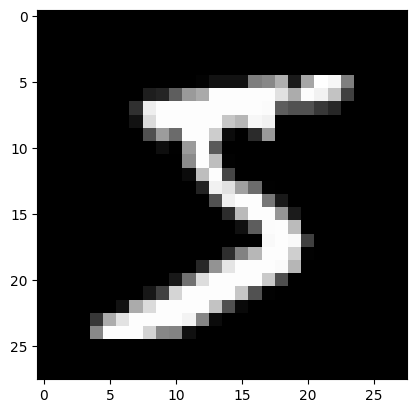

Le chiffre sur l'image est un 5


In [5]:
# On peut visualiser les éléments du dataset
plt.imshow(dataset[0][0].permute(1,2,0).numpy(), cmap='gray')
plt.show()
print("Le chiffre sur l'image est un "+str(dataset[0][1]))

## Séparation train/validation/test

Comme vous l'aurez remarqué, lors du chargement du dataset, on a chargé un train_dataset et un test_dataset. C'est une pratique que nous n'avons pas encore abordé mais qui est d'une importance capitale lors d'un entraînement de réseau de neurones.  
En effet, lorsque l'on entraîne un réseau sur des données, il est logique que celui-ci soit bon sur les données sur lesquelles il a été entraîné. Il est donc nécessaire de créer un dataset de test qui va servir à évaluer le modèle sur des données non vues pendant l'entraînement.  

En pratique, on utilise 3 sous-dataset, le "training split" que l'on utilise pour l'entraînement du modèle, le "validation split" qui est utilisé pour évaluer le modèle au cours de l'entraînement et le "testing split" qui permet d'évaluer le modèle à la fin de l'entraînement et qui est le résultat qui nous importe le plus. 

Une pratique courante est d'utiliser le split 60-20-20, c'est-à-dire 60% des données pour l'entraînement, 20% pour la validation et 20% pour le test. Cependant, cette recommandation n'est pas pertinente pour toutes les tailles de dataset. En effet, si le dataset contient énormement d'images, on peut prendre moins de données pour la validation et le test. A titre informatif, sur des datasets de plusieurs milliards d'images, on utilise souvent des splits 98-1-1 ou même 99.8-0.1-0.1.

In [6]:
#Le train et test sont déjà séparé, on va donc séparer le train_dataset en train et validation
train_dataset, validation_dataset=torch.utils.data.random_split(dataset, [0.8,0.2])

# Création des dataloaders pour séparer en mini-batch automatiquement
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader= DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Création et entraînement d'un premier modèle 

Comme dans le notebook précédent, nous allons créer un modèle entièrement connecté pour l'entraînement. Comme les données d'entrée sont des images de taille $28 \times 28$, il est nécessaire de les convertir en vecteur de taille $784$ pour les faire passer dans le réseau. 

In [8]:
class mlp(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.fc1=nn.Linear(784,256) # première couche cachée 
    self.fc2=nn.Linear(256,256) # seconde couche cachée 
    self.fc3=nn.Linear(256,10) # couche de sortie
    
  # La fonction forward est la fonction appelée lorsqu'on fait model(x)
  def forward(self,x):
    x=x.view(-1,28*28) # Pour convertir l'image de taille 28x28 en tensor de taille 784
    x=F.relu(self.fc1(x)) # le F.relu permet d'appliquer la fonction d'activation ReLU sur la sortie de notre couche 
    x=F.relu(self.fc2(x))
    output=self.fc3(x)
    return output

In [10]:
model = mlp() # Couches d'entrée de taille 2, deux couches cachées de 16 neurones et un neurone de sortie
print(model)
print("Nombre de paramètres", sum(p.numel() for p in model.parameters()))

mlp(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
Nombre de paramètres 269322


### Fonction de perte 

Pour la fonction de perte, on utilise la cross entropy loss de pytorch qui correspond à la fonction de perte de la régression logistique mais pour un nombre de classes supérieur à 2.  
La fonction de perte s'écrit comme ça :  
$\text{Cross Entropy Loss} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} y_{ic} \log(p_{ic})$  
où $N$ est le nombre d'exemple dans le mini-batch, $C$ est le nombre de classes, $y_{ic}$ est la valeur cible ($1$ si l'exemple appartient à la classe $c$ et $0$ sinon) et $p_{ic}$ est la prédiction de la probabilité d'appartenance à la classe $c$. 


In [11]:
# En pytorch
criterion = nn.CrossEntropyLoss()

### Hyperparamètres et entraînement 

In [12]:
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

Entraînement du modèle (peut durer quelques minutes en fonction de la puissance de votre ordinateur).

In [13]:
for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    preds=model(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad(): # permet de ne pas calculer les gradients
      preds=model(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.29076647758483887
step 0 val loss 0.15385286509990692
step 1 train loss 0.10695428401231766
step 1 val loss 0.10097559541463852
step 2 train loss 0.07086848467588425
step 2 val loss 0.09286081790924072
step 3 train loss 0.05028771981596947
step 3 val loss 0.08867377787828445
step 4 train loss 0.04254501312971115
step 4 val loss 0.0835222601890564


### Vérification du modèle sur les données de test

Maintenant que le modèle est entraîné, on peut regarder ses performances sur notre "testing split".

In [14]:
correct = 0
total = 0
for images,labels in test_loader: 
  with torch.no_grad():
    preds=model(images)
    
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  97.69


Notre modèle obtient une très bonne précision en phase de test ce qui est bon signe.  
Cependant, on peut remarquer que, lors de l'entraînement, le loss de training est plus bas que le loss de validation. C'est un point important à considérer. Cela signifie que le modèle est en léger "overfitting". 

## Overfitting et underfitting 

Un élément clé de l'apprentissage profond est la capacité du modèle à ne pas **overfit** les données d'entraînement. L'**overfitting** correspond à un modèle qui aurait trop bien appris sur les données d'entraînement mais qui ne serait pas capable de généraliser à de nouveaux élèments issus de la même distribution.  
Pour comprendre le principe, voici une figure faisant la différence entre **underfitting** (modèle trop simple incapable d'apprendre la complexité des données), modèle bien entrainé et **overfitting**.  
<img src="images/overfitting.png" alt="overfitting" width="800"/>

Dans le cas le plus critique de l'overfitting, le modèle a une précision presque parfaite sur les données d'entraînement mais est mauvais sur les données de validation et de test.  
Dans ce cours, nous allons introduire 2 méthodes permettant d'éviter ce problème d'overfitting. 

### Régularisation L2

La régularisation L2 est une méthode qui consiste à ajouter une pénalité à la perte basée sur la valeur des poids du modèle. Cette pénalité est proportionnelle au carré des valeurs des poids du modèle (à noter qu'il existe aussi la régularisation L1 qui est linéairement proportionnelle au valeurs des poids du modèle). Cette pénalité encourage les poids du modèle à rester petits et moins sensibles au bruit des données d'entraînement.  
On peut formuler la régularisation L2 de cette manière :  
$L(w) = L_0(w) + \lambda \sum_{i=1}^{n} w_i^2$ où $L(w)$ est la perte régularisée, $L_0(w)$ est la fonction de perte classique, $\lambda$ est le coefficient de régularisation et $w_i$ est un poid du modèle.  
Pour en apprendre plus sur la régularisation, vous pouvez consulter ce [blogpost](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c). 

Faisons à nouveau notre entraînement mais en ajoutant la régularisation. En pytorch, la régularisation s'utilise en ajoutant le paramètre weight_decay à notre optimizer. La valeur de weight_decay correspond au $\lambda$ de l'équation précédente.

In [15]:
model_with_reg=mlp()
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model_with_reg.parameters(),lr=learning_rate,weight_decay=1e-5)

for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    preds=model_with_reg(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad(): # permet de ne pas calculer les gradients
      preds=model_with_reg(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.2986273467540741
step 0 val loss 0.1439662128686905
step 1 train loss 0.11165566742420197
step 1 val loss 0.10781095176935196
step 2 train loss 0.07492929697036743
step 2 val loss 0.09555892646312714
step 3 train loss 0.05378309637308121
step 3 val loss 0.08672302216291428
step 4 train loss 0.041800014674663544
step 4 val loss 0.0883878618478775


In [16]:
correct = 0
total = 0
for images,labels in test_loader: 
  with torch.no_grad():
    preds=model_with_reg(images)
    
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  97.73


La différence n'est pas flagrante mais on constaste une diminution de la différence entre la perte de validation et la perte d'entraînement. 

**Intuition** : La régularisation L2 fonctionne parce qu'en pénalisant les grands coefficients, elle favorise des solutions où les poids sont répartis de manière plus uniforme, ce qui réduit la sensibilité du modèle aux variations spécifiques des données d'entraînement et améliore ainsi la robustesse et la généralisation du modèle.

### Dropout

Une autre méthode de régularisation est le $dropout$. Cette méthode consiste à désactiver aléatoirement un pourcentage de neurones dans le réseau à chaque étape de l'entraînement (les poids désactivés changent pendant l'entraînement). Chaque neurone d'une couche a une probabilité $p$ d'être desactivé.

Cette technique force le réseau à ne pas se reposer sur certains neurones mais plutôt à apprendre des representations plus robuste et qui généralise mieux. On peut voir le $dropout$ comme une sorte d'ensemble de modèles où chaque modèle est différent (car certains neurones sont désactivés) et lors de la phase de test, on prend la "moyenne" de ces différents modèles. Lors de la phase de test, le $dropout$ est désactivé. 

Pour appliquer le dropout, il est nécessaire de l'ajoute directement dans l'architecture du réseau. 

In [17]:
class mlp_dropout(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.fc1=nn.Linear(784,256) 
    self.dropout1 = nn.Dropout(0.2) # on désactive 50% des neurones aléatoirement
    self.fc2=nn.Linear(256,256) 
    self.dropout2 = nn.Dropout(0.2) # on désactive 50% des neurones aléatoirement
    self.fc3=nn.Linear(256,10) 
  
  def forward(self,x):
    x=x.view(-1,28*28)
    x=F.relu(self.dropout1(self.fc1(x)))
    x=F.relu(self.dropout2(self.fc2(x)))
    output=self.fc3(x)
    return output

In [18]:
model_with_dropout=mlp_dropout()
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model_with_dropout.parameters(),lr=learning_rate)

for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    preds=model_with_dropout(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad(): # permet de ne pas calculer les gradients
      preds=model_with_dropout(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.3267715573310852
step 0 val loss 0.19353896379470825
step 1 train loss 0.13504144549369812
step 1 val loss 0.14174170792102814
step 2 train loss 0.10012412816286087
step 2 val loss 0.13484247028827667
step 3 train loss 0.07837768644094467
step 3 val loss 0.10895466059446335
step 4 train loss 0.0631122887134552
step 4 val loss 0.10599609464406967


In [25]:
correct = 0
total = 0
for images,labels in test_loader: 
  with torch.no_grad():
    preds=model_with_dropout(images)
    
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  96.96


On constate à nouveau une légère amélioration du résultat de l'entraînement.

**Intuition** : Le dropout améliore la généralisation en désactivant aléatoirement des neurones pendant l'entraînement, ce qui empêche le modèle de trop se fier à certains neurones et force une distribution plus robuste et diversifiée des caractéristiques apprises.

## Batch Normalization 

Une autre technique d'amélioration de l'entraînement d'un réseau de neurones est la **Batch Normalization** (**BatchNorm**). Le principe est de normaliser les entrées de chaque couche d'une réseau avec une distribution avec une moyenne nulle et une variance de 1.  
La normalisation s'effectue sur le batch complet de la manière suivante :  

Pour un mini-batch $B$ avec activations $x$ :

$\mu_B = \frac{1}{m} \sum_{i=1}^m x_i$ la moyenne des activations $x_i$ des m éléments 


$\sigma_B^2 = \frac{1}{m} \sum_{i=1}^m (x_i - \mu_B)^2$ la variance des activations $x_i$ des m éléments 


$\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$ la valeur de $x_i$ normalisée


$y_i = \gamma \hat{x}_i + \beta$ l'ajout des paramètres $\gamma $ et $\beta$ permettre au réseau d'apprendre les distributions d'activation optimales.  


où $m$ est la taille du mini-batch $B$, $\epsilon$ est une petite constante ajoutée pour éviter la division par zéro, et $\gamma $ et $\beta$ sont des paramètres apprenables.

En pratique, on constate 4 principaux avantages lors de l'utilisation de la **BatchNorm**. 
- **Accéleration de l'entraînement** : La normalisation des entrées de chaque couche permet d'utiliser un learning rate plus élévé et donc d'accélèrer la convergence de l'entraînement.
- **Réduction de la sensibilité à l'initialisation des poids** : La **BatchNorm** permet de stabiliser la distribution des activations ce qui rend le réseau moins sensible à l'initialisation des poids. 
- **Amélioration de la généralisation** : Comme le dropout et la régularisation l2, la **BatchNorm** agit comme une forme de régularisation. Cela est dû au bruit induit par le fait de normaliser sur le batch.
- **Réduction du "Internal Covariate Shift"** : La stabilisation des activations tout au long du réseau permet de réduire le changement des distributions des couches internes ce qui facilite l'apprentissage.   

Ce qu'il faut retenir c'est que la **BatchNorm** offre de nombreux avantages et il est donc conseillé de l'utiliser systématiquement.   

Il existe également d'autres techniques de normalisation comme la LayerNorm, la InstanceNorm, la GroupNorm et d'autres ...  
Pour en apprendre plus sur la batch normalisation, vous pouvez lire le [papier](https://arxiv.org/pdf/1502.03167) ou le [blogpost](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739).   
Pour avoir des informations supplémentaires sur l'intêret de la normalisation pour l'entraînement des réseaux de neurones, vous pouvez consulter le [blogpost](https://medium.com/nerd-for-tech/overview-of-normalization-techniques-in-deep-learning-e12a79060daf).


Pour implémenter la **BatchNorm** en pytorch, il faut l'ajouter directement dans la construction de notre modèle. A noter qu'on applique souvent la **BatchNorm** avant la fonction d'activation mais que les deux approches sont possibles (avant ou après). 

In [26]:
class mlp_bn(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.fc1=nn.Linear(784,256) 
    self.bn1=nn.BatchNorm1d(256) # Batch Normalization
    self.fc2=nn.Linear(256,256) 
    self.bn2=nn.BatchNorm1d(256) # Batch Normalization
    self.fc3=nn.Linear(256,10) 
  
  def forward(self,x):
    x=x.view(-1,28*28)
    x=F.relu(self.bn1(self.fc1(x)))
    x=F.relu(self.bn1(self.fc2(x)))
    output=self.fc3(x)
    return output

In [27]:
model_with_bn=mlp_bn()
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model_with_bn.parameters(),lr=learning_rate)

for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    preds=model_with_bn(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad(): # permet de ne pas calculer les gradients
      preds=model_with_bn(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.20796926319599152
step 0 val loss 0.1327729970216751
step 1 train loss 0.09048832952976227
step 1 val loss 0.10177803039550781
step 2 train loss 0.0635765939950943
step 2 val loss 0.09861738979816437
step 3 train loss 0.045849185436964035
step 3 val loss 0.09643400460481644
step 4 train loss 0.0397462323307991
step 4 val loss 0.08524414896965027


In [28]:
correct = 0
total = 0
for images,labels in test_loader: 
  with torch.no_grad():
    preds=model_with_bn(images)
    
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  97.19


Comme vous pouvez le voir, la BatchNorm permet d'obtenir un meilleur score sur nos données dans les mêmes conditions d'entraînement. 